In [50]:
import sys
import collections
import numpy as np
from scipy.stats import norm

%matplotlib notebook
import matplotlib
import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, proj3d
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.collections import LineCollection

sys.path.append('..')
from higgs_inference.various.utils import interpolate, format_number, asymptotic_p_value, s_from_r
from higgs_inference import settings


In [2]:
colors     = ['#CC002E',  'c',    'mediumblue', 'darkgreen', 'orange']
linestyles = [  '--',   '-.',    ':',      '-.',          '--',        '-',         '--',  ':']
linewidths = [  1.5,     1.5,    2.,       1.5,            1.5,         1.5,          1.5,  2]

def lighter_color(color, fraction_white=0.5):
    rgb = np.asarray(matplotlib.colors.to_rgb(color))
    white = np.asarray((1.,1.,1.))
    return fraction_white * white + (1. - fraction_white)*rgb

def ccolor(theta):
    cmap = matplotlib.cm.get_cmap('viridis')
    return cmap((theta + 1) / 2.)

In [3]:
margin_l_absolute = 8. * 0.1
margin_r_absolute = 8. * 0.02
margin_sep_absolute = 8. * 0.02
margin_t_absolute = 8. * 0.02
margin_b_absolute = 8. * 0.08

def calculate_height(n_panels=2, width=8.):
    
    if isinstance(n_panels, collections.Sequence):
        n_panels_h, n_panels_v = n_panels
    else:
        n_panels_h = n_panels
        n_panels_v = 1
    
    # Calculate horizontal margins. Units: relative to width.
    margin_l = margin_l_absolute / width
    margin_r = margin_r_absolute / width
    margin_l_subsequent = margin_l
    if n_panels_h > 2:
        margin_l_subsequent = margin_r
    margin_sep = margin_sep_absolute / width
    if n_panels_h > 2:
        margin_sep = 0
    margin_sep_total = margin_r + margin_sep + margin_l_subsequent
    panel_width = (1. - margin_l - margin_r - (n_panels_h - 1)*margin_sep_total) / n_panels_h
    
    # Calculate wspace argument of subplots_adjust
    wspace = margin_sep_total / panel_width
    
    # Calculate absolute height
    panel_height_absolute = panel_width * width # Square plots
    height = n_panels_v * (panel_height_absolute + margin_t_absolute + margin_b_absolute) + (n_panels_v - 1) * margin_sep_absolute
    
    # Calculate horizontal margins. Units: relative to width.
    panel_height = panel_height_absolute / height
    margin_t = margin_t_absolute / height
    margin_b = margin_b_absolute / height
    margin_sep_total = (margin_t + margin_b + margin_sep_absolute / height)
    
    # Calculate wspace argument of subplots_adjust
    hspace = margin_sep_total / panel_height
    
    # Return height
    return height


def adjust_margins(n_panels=2, width=8.):
    
    if isinstance(n_panels, collections.Sequence):
        n_panels_h, n_panels_v = n_panels
    else:
        n_panels_h = n_panels
        n_panels_v = 1
    
    # Calculate horizontal margins. Units: relative to width.
    margin_l = margin_l_absolute / width
    margin_r = margin_r_absolute / width
    margin_l_subsequent = margin_l
    if n_panels_h > 2:
        margin_l_subsequent = margin_r
    margin_sep = margin_sep_absolute / width
    if n_panels_h > 2:
        margin_sep = 0
    margin_sep_total = margin_r + margin_sep + margin_l_subsequent
    panel_width = (1. - margin_l - margin_r - (n_panels_h - 1)*margin_sep_total) / n_panels_h
    
    # Calculate wspace argument of subplots_adjust
    wspace = margin_sep_total / panel_width
    
    # Calculate absolute height
    panel_height_absolute = panel_width * width # Square plots
    height = n_panels_v * (panel_height_absolute + margin_t_absolute + margin_b_absolute) + (n_panels_v - 1) * margin_sep_absolute
    
    # Calculate horizontal margins. Units: relative to width.
    panel_height = panel_height_absolute / height
    margin_t = margin_t_absolute / height
    margin_b = margin_b_absolute / height
    margin_sep_total = (margin_t + margin_b + margin_sep_absolute / height)
    
    # Calculate wspace argument of subplots_adjust
    hspace = margin_sep_total / panel_height
    
    # Set margins
    plt.subplots_adjust(left = margin_l,
                        right = 1. - margin_r,
                        bottom = margin_b,
                        top = 1. - margin_t,
                        wspace = wspace)

# Toy model

In [4]:
def pdf(x, theta):
    mean = 2. * theta + 4
    sigma = 1. + 0.2 * (theta + 1.)**2
    sigma_noise = 5.
    return norm.pdf(x, mean, sigma)


def log_likelihood(x, theta):
    return np.log(pdf(x,theta))


def score(x, theta):
    epsilon = 1.e-2
    return (log_likelihood(x, theta + epsilon) - log_likelihood(x, theta - epsilon))/ (2.*epsilon)


def samples(n, theta):
    mean = theta + 4.
    sigma = 1. + 0.5 * (theta + 1.)**2
    return np.random.normal(mean, sigma, size=n)


def draw_thetas(n, x):  # such a Bayesian thing to do! Assume flat prior over [-1,1]
    candidates = -1. + 2. * np.random.rand(10 * n)
    probabilities = pdf(x, candidates)
    probabilities /= np.sum(probabilities)
    
    return np.random.choice(candidates, n)


def add_noise(data):
    sigma_noise = 0.1
    return np.exp(np.log(data) + np.random.normal(0., sigma_noise, size=data.shape))
    


# carl vs regression

<IPython.core.display.Javascript object>


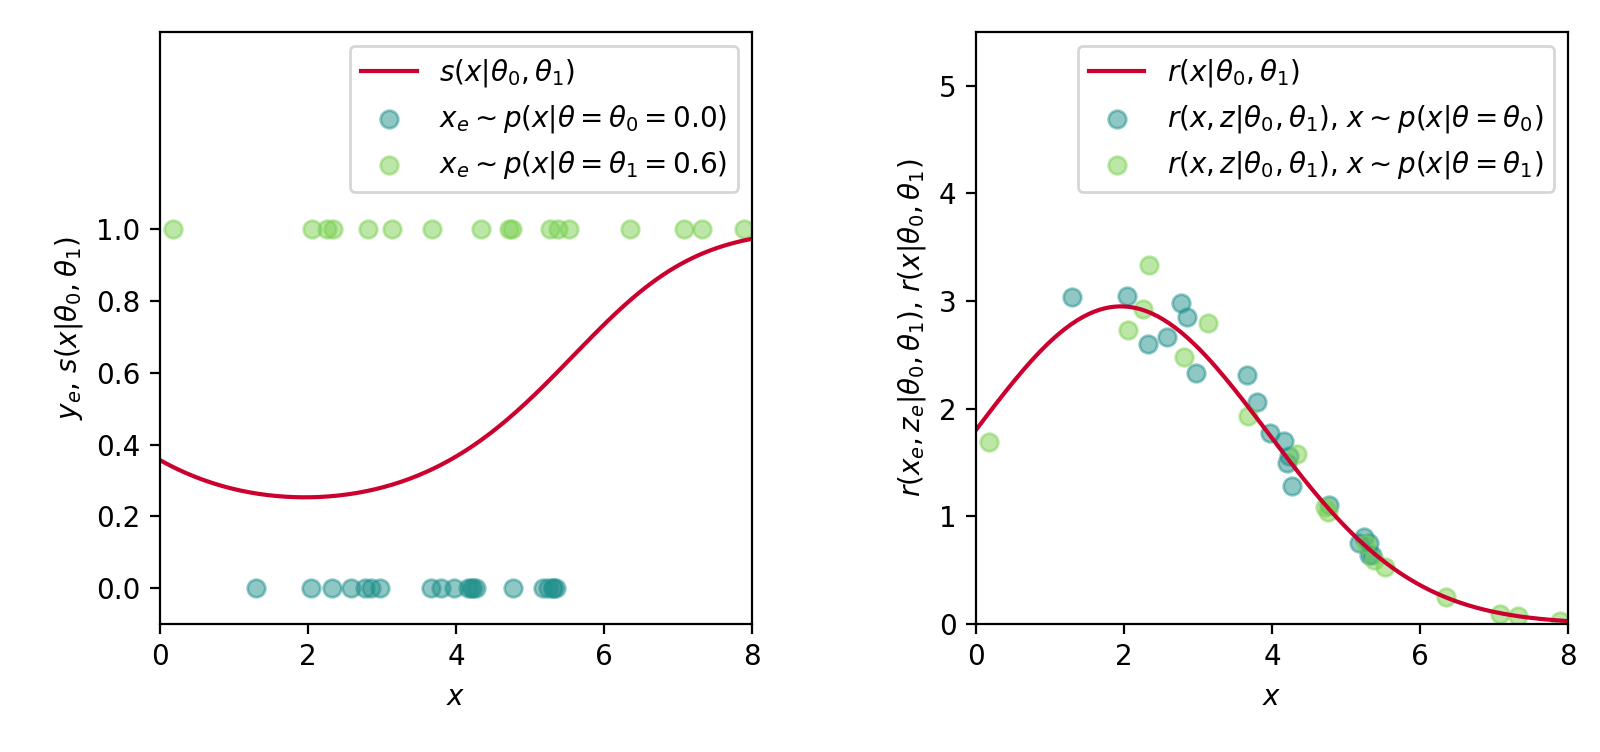

In [7]:
x = np.linspace(0.,8.,200)
theta0 = 0.
theta1 = 0.6

r = pdf(x, theta0) / pdf(x, theta1)
s = s_from_r(r)

x0 = samples(20, theta0)
x1 = samples(20, theta1)

r_x0z = add_noise(pdf(x0, theta0) / pdf(x0, theta1))
r_x1z = add_noise(pdf(x1, theta0) / pdf(x1, theta1))

plt.figure(figsize=(8, calculate_height(2,8)))



ax = plt.subplot(1,2,1)

plt.scatter(x0, np.zeros_like(x0), s=40., c=ccolor(theta0), alpha=0.5,
            label=r'$x_e \sim p(x | \theta = \theta_0 = ' + format_number(theta0, 1) + ')$')
plt.scatter(x1, np.ones_like(x1), s=40., c=ccolor(theta1), alpha=0.5,
            label=r'$x_e \sim p(x | \theta = \theta_1 = ' + format_number(theta1, 1) + ')$')
plt.plot(x, s, c=colors[0], lw=1.5,
         label=r'$s(x| \theta_0, \theta_1)$')

plt.legend(loc='upper right')

plt.xlabel('$x$')
plt.ylabel(r'$y_e$, $s(x| \theta_0, \theta_1)$')

plt.xlim(0.,8.)
plt.ylim(-0.1,1.55)
ax.set_yticks([0.,0.2,0.4,0.6,0.8,1.])



plt.subplot(1,2,2)

plt.scatter(x0, r_x0z,
            s=40., c=ccolor(theta0), alpha=0.5,
            label=r'$r(x, z| \theta_0, \theta_1)$, $x \sim p(x | \theta = \theta_0)$')
plt.scatter(x1, r_x1z,
            s=40., c=ccolor(theta1), alpha=0.5,
            label=r'$r(x, z| \theta_0, \theta_1)$, $x \sim p(x | \theta = \theta_1)$')
plt.plot(x, r, c=colors[0], lw=1.5,
         label=r'$r(x| \theta_0, \theta_1)$')

plt.legend(loc='upper right')

plt.xlabel('$x$')
plt.ylabel(r'$r(x_e, z_e| \theta_0, \theta_1)$, $r(x|\theta_0, \theta_1)$')

plt.xlim(0.,8.)
plt.ylim(0.,5.5)



adjust_margins(2,8.)

plt.savefig('../figures/paper/illustration_carl_regression.pdf')

# Score

<IPython.core.display.Javascript object>


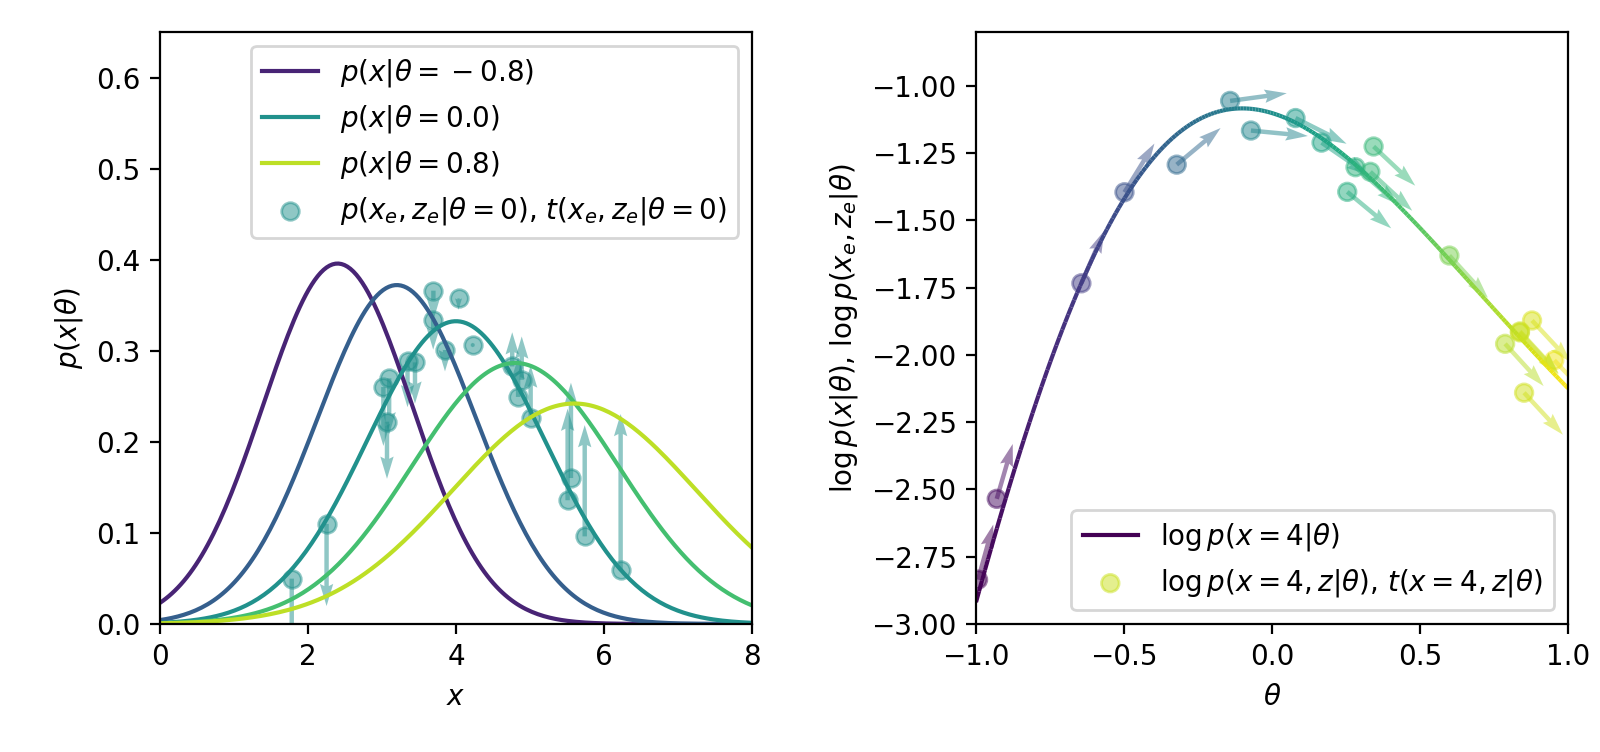

In [9]:
plt.figure(figsize=(8, calculate_height(2,8)))

plt.subplot(1,2,1)

x = np.linspace(0.,8.,200)
thetas = [-0.8,-0.4,0.,0.4,0.8]

theta0 = 0.
x0 = samples(20, theta0)
p_x0 = add_noise(pdf(x0, theta0))
t_x0 = score(x0, theta0)

for i, theta in enumerate(thetas):
    color=ccolor(theta)
    p = pdf(x, theta)
    logp = log_likelihood(x, theta)
    t = score(x, theta)
    
    if i in [0,2,4]:
        plt.plot(x, p, color=color,
                 label= r'$p(x | \theta =' + format_number(theta,1) + ')$')
    else:
        plt.plot(x, p, color=color)
        
plt.scatter(x0, p_x0,
            s=40., c=ccolor(theta0), alpha=0.5,
            label=r'$p(x_e, z_e| \theta = 0)$, $t(x_e, z_e | \theta = 0)$')
    
plt.quiver(x0, p_x0, 0., t_x0, 
           scale=5, units='inches',
           alpha=0.5, color=ccolor(theta0))

plt.legend()

plt.xlim(0.,8.)
plt.ylim(0.,0.65)
plt.xlabel('$x$')
plt.ylabel(r'$p(x| \theta)$')



ax = plt.subplot(1,2,2)

x = 4.
thetas = np.linspace(-1.,1.,200)
theta1 = 0.6
logr = log_likelihood(x, thetas) #- log_likelihood(x, theta1)

th0 = draw_thetas(20, x)
logr_th0 = np.log(add_noise(pdf(x, th0)))
t_th0 = score(x, th0)
x_t_th0 = np.ones_like(t_th0)
lengths = (t_th0**2 + x_t_th0**2)**0.5
t_th0 /= lengths
x_t_th0 /= lengths

#plt.plot(thetas, logr, color=colors[0], ls='-', lw=1.5,
#         label= r'$\log p(x | \theta =' + format_number(theta,0) + ')$')
linenorm = plt.Normalize(-1.,1.)
points = np.array([thetas, logr]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = LineCollection(segments, cmap='viridis', norm=linenorm)
lc.set_array(thetas)
lc.set_linewidth(1.5)
line = ax.add_collection(lc)
proxy = plt.plot([], [], color=ccolor(-1.), ls='-', lw=1.5,
                label=r'$\log \, p(x = 4| \theta)$')

plt.scatter(th0, logr_th0,
            s=40., c=[ccolor(t0) for t0 in th0], alpha=0.5,
            label=r'$\log \, p(x=4, z| \theta)$, $t(x=4, z | \theta)$')
    
plt.quiver(th0, logr_th0, x_t_th0, t_th0, 
           scale=3.5, units='inches', angles='xy',
           alpha=0.5, color=[ccolor(t0) for t0 in th0])

plt.legend(loc='lower right')

plt.xlim(-1.,1.)
plt.ylim(-3.,-0.8)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\log \, p(x| \theta)$, $\log \, p(x_e, z_e| \theta)$')



adjust_margins(2,8.)

plt.savefig('../figures/paper/illustration_score.pdf')

# 3d plot

<IPython.core.display.Javascript object>


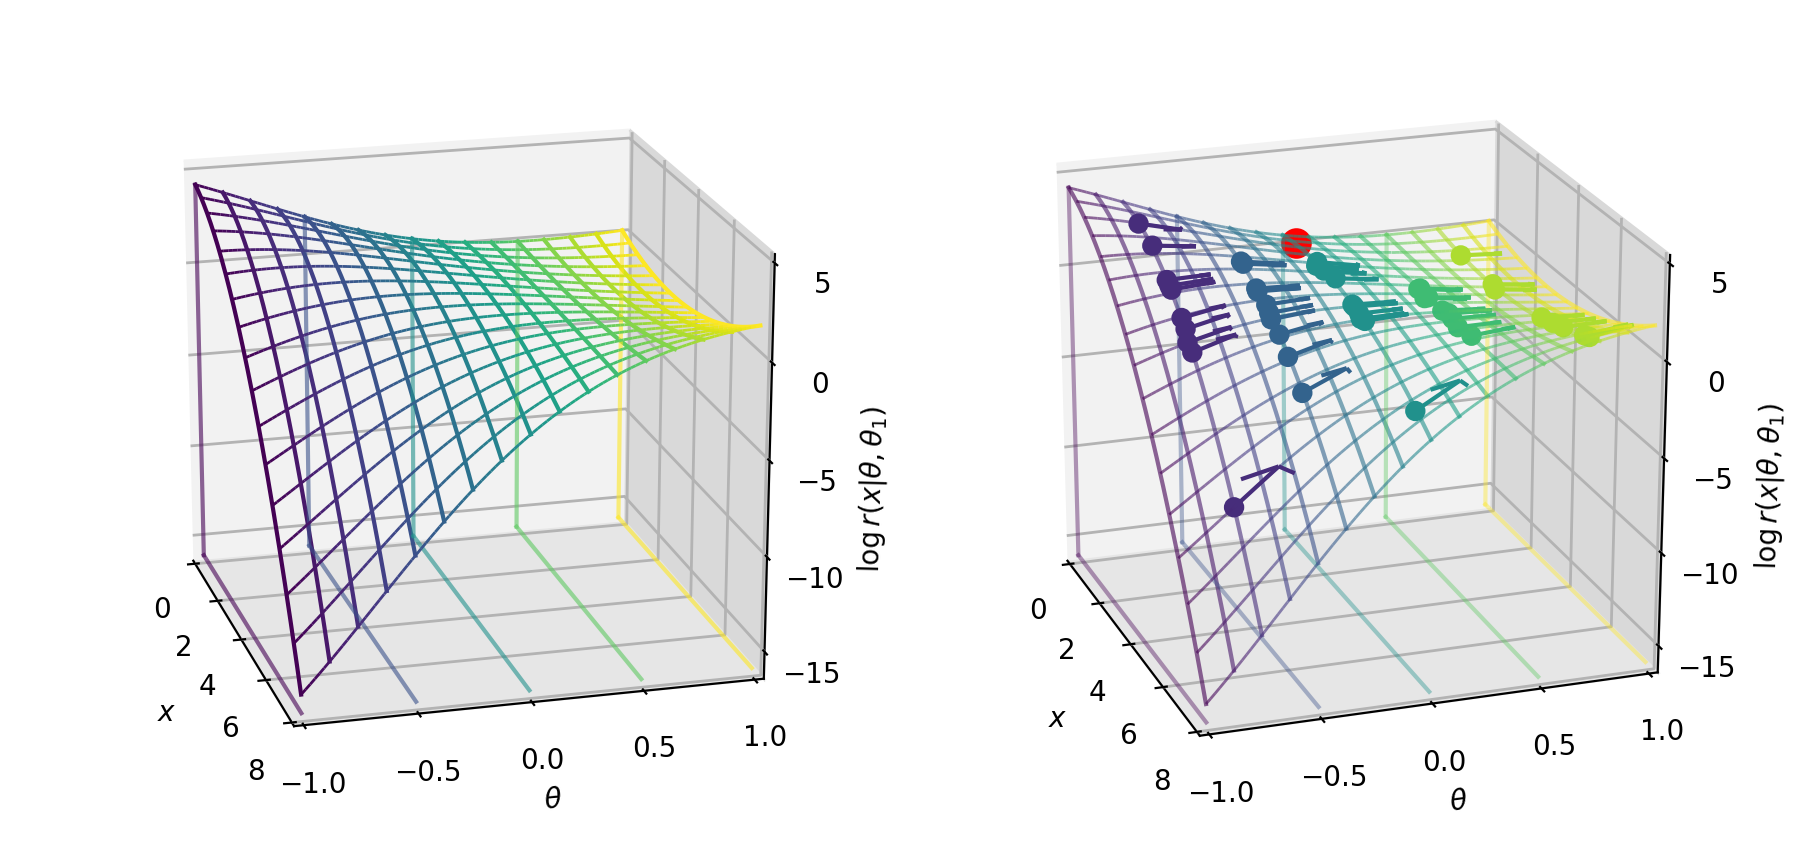

-0.014209491574346762 0.062357008488345654


In [57]:
rmin, rmax = -16.,5.
t = np.linspace(-1.,1.,100)
x = np.linspace(0.,8.,200)
thetas_lines = np.linspace(-1.,1.,17)
thetas_dots = np.linspace(-0.75,0.75,5)
n_dots_per_theta = 10
xlines = np.linspace(0.,8.,17)
theta1 = 0.4

plt.figure(figsize=(9., calculate_height(2,9.)))



ax = plt.subplot(1,2,1, projection='3d')
ax.view_init(elev=20., azim=-15)

for k, theta0 in enumerate(thetas_lines):
    r = np.log(pdf(x, theta0) / pdf(x, theta1))
    #r = np.log(pdf(x, theta0))

    _theta0x = np.zeros_like(x)
    _theta0x[:] = theta0
        
    ax.plot(x, _theta0x, r,
            c=ccolor(theta0), lw=1.5, alpha=1.)
    
    if k % 4 == 0:
        ax.plot([0.,8.], [theta0,theta0], [rmin,rmin],
               c=ccolor(theta0), lw=1.5, alpha=.6)
        ax.plot([0.,0.], [theta0,theta0], [rmin,r[0]],
               c=ccolor(theta0), lw=1.5, alpha=.6)
        #ax.plot([8.,8.], [theta0,theta0], [rmin,r[-1]],
        #       c=ccolor(theta0), lw=1.5, alpha=.4)
    
for xl in xlines:
    segments = []
    for t_begin, t_end in zip(t[:-1], t[1:]):
        r_begin = np.log(pdf(xl, t_begin) / pdf(xl, theta1))
        #r_begin = np.log(pdf(xl, t_begin))
        r_end = np.log(pdf(xl, t_end) / pdf(xl, theta1))
        #r_end = np.log(pdf(xl, t_end))
        segments.append( [(xl, t_begin, r_begin), (xl, t_end, r_end)] )
    segments = np.asarray(segments)

    lc = Line3DCollection(segments, cmap='viridis')
    lc.set_array(t[:-1])
    lc.set_linewidth(1.)
    lc.set_alpha(1.)

    ax.add_collection(lc)
    
ax.set_xlabel('$x$')
ax.set_zlabel(r'$\log \, r(x| \theta, \theta_1)$')
ax.set_ylabel(r'$\theta$')
ax.set_xlim(0.,8.)
ax.set_zlim(rmin, rmax)
ax.set_ylim(-1.,1.)
ax.set_xticks([0.,2.,4.,6.,8.])
ax.set_yticks([-1.,-0.5,0.,0.5,1.])
ax.set_zticks([-15.,-10.,-5.,0.,5.])

ax.dist = 10.

ax.w_xaxis.set_pane_color((0.95, 0.95, 0.95, 1.0))
ax.w_yaxis.set_pane_color((0.85, 0.85, 0.85, 1.0)) 
ax.w_zaxis.set_pane_color((0.9, 0.9, 0.9, 1.0)) 
ax.w_xaxis._axinfo.update({'grid' : {'color': (0.7, 0.7, 0.7, 1.),
                                    'linewidth': 1.,
                                    'linestyle': '-'}})
ax.w_yaxis._axinfo.update({'grid' : {'color': (0.7, 0.7, 0.7, 0.),
                                    'linewidth': 1.,
                                    'linestyle': '-'}})
ax.w_zaxis._axinfo.update({'grid' : {'color': (0.7, 0.7, 0.7, 1.),
                                    'linewidth': 1.,
                                    'linestyle': '-'}})



ax = plt.subplot(1,2,2, projection='3d')
ax.view_init(elev=20., azim=-15)

for k, theta0 in enumerate(thetas_lines):
    r = np.log(pdf(x, theta0) / pdf(x, theta1))
    #r = np.log(pdf(x, theta0))

    _theta0x = np.zeros_like(x)
    _theta0x[:] = theta0
        
    ax.plot(x, _theta0x, r,
            c=ccolor(theta0), lw=1.5, alpha=0.6)
    
    if k % 4 == 0:
        ax.plot([0.,8.], [theta0,theta0], [rmin,rmin],
               c=ccolor(theta0), lw=1.5, alpha=.4)
        ax.plot([0.,0.], [theta0,theta0], [rmin,r[0]],
               c=ccolor(theta0), lw=1.5, alpha=.4)
        #ax.plot([8.,8.], [theta0,theta0], [rmin,r[-1]],
        #       c=ccolor(theta0), lw=1.5, alpha=.4)
    
for xl in xlines:
    segments = []
    for t_begin, t_end in zip(t[:-1], t[1:]):
        r_begin = np.log(pdf(xl, t_begin) / pdf(xl, theta1))
        #r_begin = np.log(pdf(xl, t_begin))
        r_end = np.log(pdf(xl, t_end) / pdf(xl, theta1))
        #r_end = np.log(pdf(xl, t_end))
        segments.append( [(xl, t_begin, r_begin), (xl, t_end, r_end)] )
    segments = np.asarray(segments)

    lc = Line3DCollection(segments, cmap='viridis')
    lc.set_array(t[:-1])
    lc.set_linewidth(1.)
    lc.set_alpha(0.6)

    ax.add_collection(lc)

for k, theta0 in enumerate(thetas_dots[:]):
    x0 = samples(n_dots_per_theta, theta0)
    if k ==0:
        x0[0] = 6.5
    x0 = x0[(x0>0.) & (x0<8.)]
    r_x0z = np.log(add_noise(pdf(x0, theta0) / pdf(x0, theta1)))
    #r_x0z = np.log(add_noise(pdf(x0, theta0)))
    
    scores_x0z = score(x0, theta0)
    x_scores_x0z = np.ones_like(scores_x0z)

    _theta0s = np.zeros_like(x0)
    _theta0s[:] = theta0
        
    ax.scatter(x0, _theta0s, r_x0z,
               s=40., c=ccolor(theta0), alpha=1.)
    tailored_quiver(ax,
                    x0, _theta0s, r_x0z,
                    np.zeros_like(scores_x0z), 0.2 * x_scores_x0z, 0.2 * scores_x0z,
                    color=ccolor(theta0))
    #ax.quiver(x0, _theta0s, r_x0z,
    #          np.zeros_like(scores_x0z), 0.2 * x_scores_x0z, 0.2 * scores_x0z,
    #          normalize=False,
    #          arrow_length_ratio=0.25, lw=1.5,
    #          color=ccolor(theta0), alpha=1.)
    
x2d, y2d, _ = proj3d.proj_transform(-1., 0., 5, ax.get_proj())
print(x2d, y2d)
#x2, y2 = ax.transData.transform((x2, y2))
plt.scatter([x2d],[y2d], s=100.,c='r')
    
ax.set_xlabel('$x$')
ax.set_zlabel(r'$\log \, r(x| \theta, \theta_1)$')
ax.set_ylabel(r'$\theta$')
ax.set_xlim(0.,8.)
ax.set_zlim(rmin, rmax)
ax.set_ylim(-1.,1.)
ax.set_xticks([0.,2.,4.,6.,8.])
ax.set_yticks([-1.,-0.5,0.,0.5,1.])
ax.set_zticks([-15.,-10.,-5.,0.,5.])

ax.dist = 10.

ax.w_xaxis.set_pane_color((0.95, 0.95, 0.95, 1.0))
ax.w_yaxis.set_pane_color((0.85, 0.85, 0.85, 1.0)) 
ax.w_zaxis.set_pane_color((0.9, 0.9, 0.9, 1.0)) 
ax.w_xaxis._axinfo.update({'grid' : {'color': (0.7, 0.7, 0.7, 1.),
                                    'linewidth': 1.,
                                    'linestyle': '-'}})
ax.w_yaxis._axinfo.update({'grid' : {'color': (0.7, 0.7, 0.7, 0.),
                                    'linewidth': 1.,
                                    'linestyle': '-'}})
ax.w_zaxis._axinfo.update({'grid' : {'color': (0.7, 0.7, 0.7, 1.),
                                    'linewidth': 1.,
                                    'linestyle': '-'}})



#adjust_margins(2,9.)
plt.tight_layout()

plt.savefig('../figures/paper/illustration_3d.pdf')

In [ ]:
def tailord_quiver(ax, x, y, z, u, v, w, color):
    begin_x = x
    begin_y = y
    begin_z = z
    end_x = (x + u)
    end_y = (y + v)
    end_z = (z + w)
    ax.plot(begin lw=1.5,
    #          color=ccolor(theta0), alpha=1.)